In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
tmp = np.load('eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

In [4]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

In [5]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.6706, Test Loss: 0.6495
Epoch 2/200, Loss: 0.5534, Test Loss: 0.6415
Epoch 3/200, Loss: 0.4955, Test Loss: 0.6350
Epoch 4/200, Loss: 0.4668, Test Loss: 0.6219
Epoch 5/200, Loss: 0.4308, Test Loss: 0.5703
Epoch 6/200, Loss: 0.4118, Test Loss: 0.5798
Epoch 7/200, Loss: 0.3757, Test Loss: 0.5584
Epoch 8/200, Loss: 0.3503, Test Loss: 0.5742
Epoch 9/200, Loss: 0.3602, Test Loss: 0.5613
Epoch 10/200, Loss: 0.3651, Test Loss: 0.5741
Epoch 11/200, Loss: 0.3370, Test Loss: 0.5415
Epoch 12/200, Loss: 0.3321, Test Loss: 0.5231
Epoch 13/200, Loss: 0.3248, Test Loss: 0.5495
Epoch 14/200, Loss: 0.3220, Test Loss: 0.5438
Epoch 15/200, Loss: 0.3230, Test Loss: 0.5479
Epoch 16/200, Loss: 0.3238, Test Loss: 0.5539
Epoch 17/200, Loss: 0.3213, Test Loss: 0.5500
Epoch 18/200, Loss: 0.3212, Test Loss: 0.5494
Epoch 19/200, Loss: 0.3212, Test Loss: 0.5494
Epoch 20/200, Loss: 0.3212, Test Loss: 0.5496
Epoch 21/200, Loss: 0.3212, Test Loss: 0.5496
Epoch 22/200, Loss: 0.3212, Test Loss: 0.54

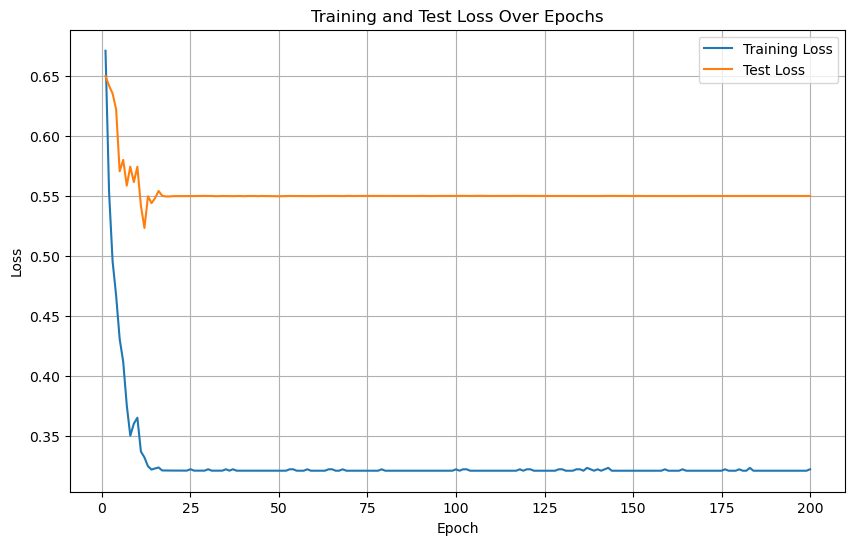

In [8]:
import matplotlib.pyplot as plt

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Compute the minimum train and test loss achieved during training
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)

print(f"Minimum Training Loss: {min_train_loss:.4f}")
print(f"Minimum Test Loss: {min_test_loss:.4f}")

Minimum Training Loss: 0.3211
Minimum Test Loss: 0.5231


In [11]:
import torch
import torch.nn as nn

class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=dropout)  # Dropout after flattening
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.dropout2 = nn.Dropout(p=dropout)  # Dropout after fully connected layer 1
        self.fc2 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(p=dropout)  # Dropout after fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        x = self.dropout1(x)  # Apply dropout after flattening
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)  # Apply dropout after fully connected layer 1
        x = torch.relu(self.fc2(x))
        x = self.dropout3(x)  # Apply dropout after fully connected layer 2
        x = self.fc3(x)
        x = self.softmax(x)

        return x


In [12]:

# Instantiate the model with a dropout rate of 0.2
input_channels = X_train.shape[1]  # Assuming X_train is defined
input_timepoints = X_train.shape[2]
num_classes = len(torch.unique(y_train))  # Assuming y_train is defined
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.2)

# Train the model for 200 epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)


Epoch 1/200, Loss: 0.6957, Test Loss: 0.6731
Epoch 2/200, Loss: 0.6448, Test Loss: 0.6508
Epoch 3/200, Loss: 0.5965, Test Loss: 0.6306
Epoch 4/200, Loss: 0.5681, Test Loss: 0.6131
Epoch 5/200, Loss: 0.5103, Test Loss: 0.5970
Epoch 6/200, Loss: 0.5107, Test Loss: 0.5419
Epoch 7/200, Loss: 0.4762, Test Loss: 0.5823
Epoch 8/200, Loss: 0.4557, Test Loss: 0.5480
Epoch 9/200, Loss: 0.4328, Test Loss: 0.5326
Epoch 10/200, Loss: 0.4342, Test Loss: 0.5202
Epoch 11/200, Loss: 0.4359, Test Loss: 0.5353
Epoch 12/200, Loss: 0.4043, Test Loss: 0.5179
Epoch 13/200, Loss: 0.4022, Test Loss: 0.5204
Epoch 14/200, Loss: 0.3944, Test Loss: 0.5066
Epoch 15/200, Loss: 0.3755, Test Loss: 0.5105
Epoch 16/200, Loss: 0.3830, Test Loss: 0.5439
Epoch 17/200, Loss: 0.3747, Test Loss: 0.5226
Epoch 18/200, Loss: 0.3595, Test Loss: 0.5065
Epoch 19/200, Loss: 0.3591, Test Loss: 0.5216
Epoch 20/200, Loss: 0.3532, Test Loss: 0.5431
Epoch 21/200, Loss: 0.3597, Test Loss: 0.5192
Epoch 22/200, Loss: 0.3430, Test Loss: 0.52

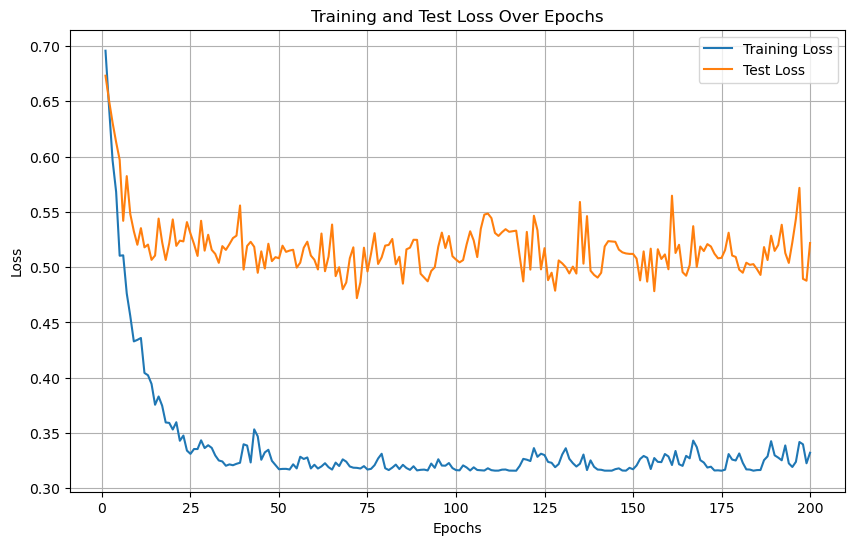

In [13]:
# Plot the training and test loss
epochs = range(1, 201)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [14]:
# Compute the minimum train and test loss
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum Training Loss: {min_train_loss}")
print(f"Minimum Test Loss: {min_test_loss}")

Minimum Training Loss: 0.3158840611577034
Minimum Test Loss: 0.4720015227794647


In [15]:
# Instantiate the EEGCNNwithDropout model with a dropout rate of 0.5
model = EEGCNNwithDropout(input_channels=input_channels, input_timepoints=input_timepoints, num_classes=num_classes, dropout=0.5)

# Move the model to the available device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)


Epoch 1/200, Loss: 0.7019, Test Loss: 0.6929
Epoch 2/200, Loss: 0.6824, Test Loss: 0.6841
Epoch 3/200, Loss: 0.6729, Test Loss: 0.6699
Epoch 4/200, Loss: 0.6367, Test Loss: 0.6562
Epoch 5/200, Loss: 0.6283, Test Loss: 0.6367
Epoch 6/200, Loss: 0.6054, Test Loss: 0.6376
Epoch 7/200, Loss: 0.5746, Test Loss: 0.6178
Epoch 8/200, Loss: 0.5724, Test Loss: 0.6168
Epoch 9/200, Loss: 0.5352, Test Loss: 0.5861
Epoch 10/200, Loss: 0.5208, Test Loss: 0.5792
Epoch 11/200, Loss: 0.5036, Test Loss: 0.5661
Epoch 12/200, Loss: 0.4906, Test Loss: 0.5309
Epoch 13/200, Loss: 0.4585, Test Loss: 0.5423
Epoch 14/200, Loss: 0.4811, Test Loss: 0.5562
Epoch 15/200, Loss: 0.4549, Test Loss: 0.5332
Epoch 16/200, Loss: 0.4647, Test Loss: 0.5248
Epoch 17/200, Loss: 0.4200, Test Loss: 0.5010
Epoch 18/200, Loss: 0.4300, Test Loss: 0.5145
Epoch 19/200, Loss: 0.4111, Test Loss: 0.5243
Epoch 20/200, Loss: 0.4140, Test Loss: 0.5483
Epoch 21/200, Loss: 0.4102, Test Loss: 0.4697
Epoch 22/200, Loss: 0.3970, Test Loss: 0.46

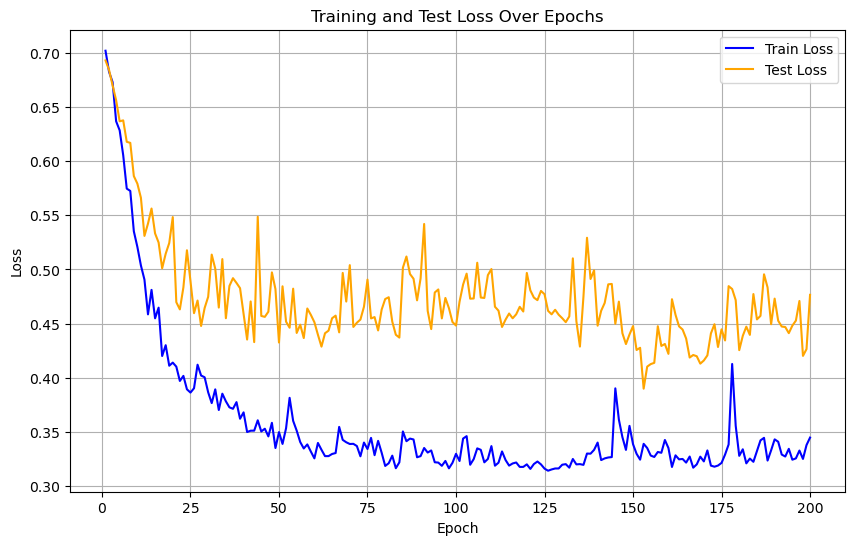

In [16]:
# Task 8: Plot training and test loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, 201), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Task 9: Compute the minimum train and test loss achieved during training and report them
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum Train Loss: {min_train_loss:.4f}")
print(f"Minimum Test Loss: {min_test_loss:.4f}")

Minimum Train Loss: 0.3142
Minimum Test Loss: 0.3899


Epoch 1/200, Loss: 0.7371, Test Loss: 0.7149
Epoch 2/200, Loss: 0.7323, Test Loss: 0.7053
Epoch 3/200, Loss: 0.7318, Test Loss: 0.6986
Epoch 4/200, Loss: 0.7234, Test Loss: 0.6922
Epoch 5/200, Loss: 0.6939, Test Loss: 0.6924
Epoch 6/200, Loss: 0.6884, Test Loss: 0.6892
Epoch 7/200, Loss: 0.7154, Test Loss: 0.6844
Epoch 8/200, Loss: 0.7186, Test Loss: 0.6815
Epoch 9/200, Loss: 0.6971, Test Loss: 0.6804
Epoch 10/200, Loss: 0.6930, Test Loss: 0.6780
Epoch 11/200, Loss: 0.6990, Test Loss: 0.6718
Epoch 12/200, Loss: 0.6988, Test Loss: 0.6638
Epoch 13/200, Loss: 0.6792, Test Loss: 0.6603
Epoch 14/200, Loss: 0.6780, Test Loss: 0.6619
Epoch 15/200, Loss: 0.6771, Test Loss: 0.6605
Epoch 16/200, Loss: 0.6646, Test Loss: 0.6555
Epoch 17/200, Loss: 0.6834, Test Loss: 0.6487
Epoch 18/200, Loss: 0.6497, Test Loss: 0.6454
Epoch 19/200, Loss: 0.6651, Test Loss: 0.6414
Epoch 20/200, Loss: 0.6688, Test Loss: 0.6358
Epoch 21/200, Loss: 0.6749, Test Loss: 0.6333
Epoch 22/200, Loss: 0.6657, Test Loss: 0.62

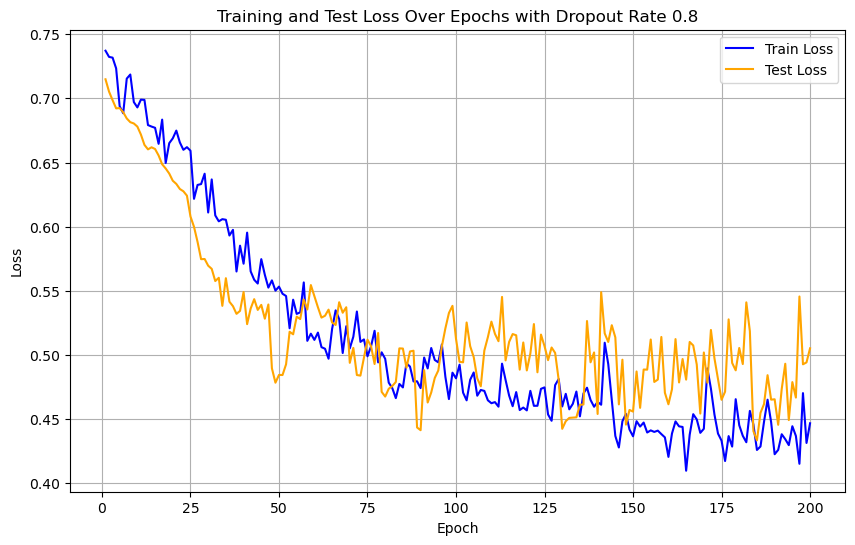

Minimum Train Loss: 0.4098
Minimum Test Loss: 0.4334


In [18]:
# Instantiate the EEGCNNwithDropout model with a dropout rate of 0.8
model = EEGCNNwithDropout(input_channels=input_channels, input_timepoints=input_timepoints, num_classes=num_classes, dropout=0.8)

# Move the model to the available device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

# Task 8: Plot training and test loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, 201), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs with Dropout Rate 0.8')
plt.legend()
plt.grid(True)
plt.show()

# Task 9: Compute the minimum train and test loss achieved during training and report them
min_train_loss = min(train_losses)
min_test_loss = min(test_losses)
print(f"Minimum Train Loss: {min_train_loss:.4f}")
print(f"Minimum Test Loss: {min_test_loss:.4f}")


## Observations with Dropout Rate 0.8

After training the EEGCNN model with a dropout rate of 0.8 for 200 epochs, the following observations were made:

- **Training Loss Trends**:
  - The training loss showed slower convergence compared to models trained with lower dropout rates.
  - This indicates that with a dropout rate of 0.8, a large portion of the model's connections are randomly deactivated, making it difficult for the model to memorize patterns from the training data.

- **Test Loss Trends**:
  - Test loss was similar to or higher than training loss, suggesting that the model is underfitting due to excessive regularization.

- **Train vs Test Loss Gap**:
  - The gap between training and test loss was relatively small compared to lower dropout rates. This is consistent with underfitting rather than overfitting.

- **Implications of a High Dropout Rate**:
  - A dropout rate of 0.8 leads to underfitting because 80% of the neurons are randomly turned off during each training iteration.
  - This demonstrates that while dropout is effective for regularization, setting it too high can impair the model's learning ability.

### Conclusion:
The high dropout rate has prevented the model from effectively learning patterns, highlighting the trade-off between regularization and model capacity. A lower dropout rate may be necessary to strike a balance between avoiding overfitting and allowing the model to generalize well.
